---
Material for the course "Introducción a la inteligencia artificial" UNIZAR

The following notes written by SERGIO G RODRIGO (2023-2024)</font>




---
**Magnetism, images and neural networks: 2D Ising model**
---


The Ising model originates from the study of magnetic materials and aims to reproduce the essential qualitative properties of some of these materials. One of the main properties of these materials is the existence of a phase transition at a certain temperature, which separates two different behaviors of the material. Above this temperature, referred to as the "critical temperature" or "Curie temperature," magnetic materials are in a paramagnetic state where electron spins are randomly oriented. As the temperature decreases, these spins begin to align, forming groups with the same orientation, leading to different magnetic domains. Below the Curie temperature, magnetic materials exhibit spontaneous magnetization, causing the mentioned domains to grow larger until all spins achieve the same orientation.

In this work, we will consider the two-dimensional Ising model with nearest-neighbor interactions. Only two possible spin orientations are considered: spin up and spin down. The model's arrangement will be a grid of spins with dimensions $L \times L$, where each of the $L^2 = V$ spins can take two values:

$S = \begin{cases}
+1 & \text{if the spin is up} \\
-1 & \text{if the spin is down}
\end{cases}$

The system's Hamiltonian is given by the following expression:
$H = -J \sum_{\langle i, j \rangle} S_i S_j - H \sum_{i=1}^V S_i \quad (1)$

Here, $J$ is a constant representing ferromagnetic interaction strength. It can be factored out of the sum due to nearest-neighbor interactions (on a square lattice, a spin only interacts with its top, bottom, right, and left neighbors) and equal magnitudes for all pairs. Additionally, the sign of $J$ determines the magnetic properties of the material: if $J$ is positive, the material exhibits ferromagnetic behavior, while if it's negative, the behavior is antiferromagnetic. The first summation is taken over all possible pairs of spins $\langle i, j \rangle$, and $H$ represents an external magnetic field.

In the absence of an external magnetic field, which is the case we'll consider, we can omit the second term of Equation (1).

Each set of $L \times L$ spins is referred to as a configuration. There are many possible different configurations of the 2D Ising network, but some are more likely to appear than others. Let's consider a specific configuration $C_\alpha$. The probability of encountering this configuration depends on its energy and temperature and is given by:

$p(C_\alpha) = \frac{1}{Z(\beta)} e^{-\beta H(C_\alpha)} \quad (2)$

Here, we've defined $\beta = (k_B T)^{-1}$, where $k_B$ is the Boltzmann constant, taken to be 1 throughout this work. $Z$ is the partition function, defined as per Equation (11), where the summation spans all possible configurations:

$Z(\beta) = \frac{1}{\sum_C e^{-\beta H(C_\alpha)}} \quad (11)$

In addition to energy, another relevant quantity for configurations is magnetization. We mentioned earlier that during a phase transition, below the Curie temperature, spontaneous magnetization appears. Its significance stems from being the order parameter in the transition. Magnetization and its intensive magnitude can be defined as follows:

$M = \sum_j S_j \quad \text{and} \quad m = \frac{1}{V} \sum_j S_j \quad (3)$

In other words, magnetization is the sum of all spins. Considering that in the paramagnetic state, spins have random orientations, the expected value of magnetization is 0. However, in the ferromagnetic state, all spins align to create an ordered configuration, and the intensive magnetization is expected to have a value of +1 or -1, depending on the preferred orientation direction of the spins: up or down.

# Main imports

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import datetime
'''
Tensorflow libraries
'''
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization

# Auxiliary functions and global variables


In [88]:
def show_ising_config(n, m, x, y,L):
    fig = plt.figure(figsize=(9, 13))
    columns = n
    rows = m
    ax = []
    for i in range(columns*rows):
        img = np.transpose(x[i,:].reshape([L,L]))
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("Beta="+str(y[i,0]))  # set title
        plt.imshow(img)
    plt.show()

# Upload Ising spin configurations and temperatures ($\beta$)


In [3]:
file_config = 'Config_testL20_entero_50betas.txt'
file_temp   = 'Temperature_testL20_entero_50betas.txt'

In [4]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Config_testL20_entero_50betas.txt to Config_testL20_entero_50betas.txt
Saving Temperature_testL20_entero_50betas.txt to Temperature_testL20_entero_50betas.txt
User uploaded file "Config_testL20_entero_50betas.txt" with length 69979441 bytes
User uploaded file "Temperature_testL20_entero_50betas.txt" with length 500000 bytes


**File descriptions:**
+ $\beta \in [0,1]$.
+ $\Delta \beta=0.02$, so a total of 50 values of $\beta$.
+ 1000 configurations for each $\beta$.

In [114]:
# Read spin configurations
df = pd.read_csv(file_config, sep='\t')
ising_configs = df.to_numpy()

# Read beta (temperatures)
df = pd.read_csv(file_temp, sep='\t')
ising_betas = df.to_numpy()

# Describe datasets
nconfiguraciones = ising_configs.shape[0]
nspines = ising_configs.shape[1]
print('Number of configurations:', nconfiguraciones)
print('Number of total atoms:', nspines)
print('Number of different temperatures:', np.unique(ising_betas))

Number of configurations: 49999
Number of total atoms: 400
Number of different temperatures: [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98]


# Training and test datasets

+ Training and validation $\beta \in [0, 0.37] \cup [0.5, 1]$
+ Test$\beta \in [0, 1]$

(42999, 400)
(42999, 1)


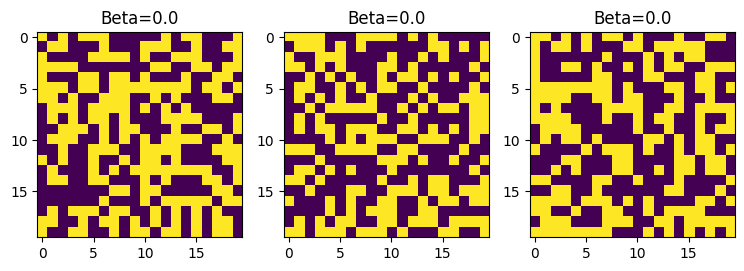



Ordered phase configurations= 24000
Random phase configurations= 18999


In [115]:
# Lattice size
L=int(np.sqrt(nspines))

# Number of labels ()
nlabels = 2
beta_low= ising_betas < 0.37
beta_high=ising_betas > 0.5

# Excludes a range around beta_c
x_train = np.vstack((ising_configs[np.squeeze(beta_low)],
                     ising_configs[np.squeeze(beta_high)]))
y_train = np.vstack((ising_betas[np.squeeze(beta_low)],
                     ising_betas[np.squeeze(beta_high)]))

# Includes the range around beta_c
x_test  = ising_configs
y_test  = ising_betas

# Before randomize configurations
show_ising_config(3, 1, x_train, y_train,L)

# Shuffle training data
nconfig_train=x_train.shape[0]
shuffle_list = np.random.permutation(range(nconfig_train))
x_train = x_train[shuffle_list, :]
y_train = y_train[shuffle_list,:]
print('\n')

# One hot encoding
# Beta <0.5 -> 0 ; Beta > 0.5 -> 1
def one_hot_encoding(y, nlabels):
    nimagenes = y.shape[0]
    y1h = np.zeros([nimagenes, nlabels])
    for image in range(nimagenes):
        if (y[image,0]>=0.5):
          y1h[image,0] = 1
          y1h[image,1] = 0
        else:
          y1h[image,0] = 0
          y1h[image,1] = 1
    return y1h

y1h_train = one_hot_encoding(y_train, nlabels)

print("Ordered phase configurations=",np.count_nonzero(y1h_train[:,0] == 1.0))
print("Random phase configurations=",np.count_nonzero(y1h_train[:,0] == 0.0))

First 3 one hot encondings= 
 [[1. 0.]
 [0. 1.]
 [1. 0.]]


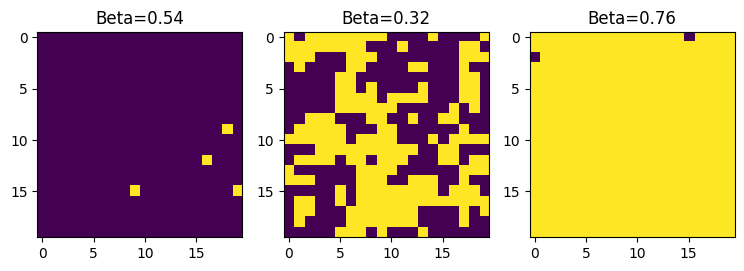

In [117]:
# After randomize configurations
print("First 3 one hot encondings= \n",y1h_train[0:3])
show_ising_config(3, 1, x_train, y_train,L)

# Run the model

In [125]:
neurons_in=x_train.shape[1]
epochs=10
mini_batch_size = 64
print("Neurons on the input layer =",neurons_in)

'''
Setup of Tensorflow model
'''
print(x_train.shape)
x_train=x_train.reshape((len(x_train),L,L,1))
#x_val=x_val.reshape((len(x_val),L,L,1))
print(x_train.shape)

img_cols=x_train.shape[1]
img_rows=x_train.shape[2]
input_shape = (img_cols,img_rows,1)

model = Sequential()
#----------------------------- CONV2D
model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',\
                  input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
#------------------------------CONV2D
model.add(layers.Dense(50, activation='relu')) # new dense layer added
model.add(layers.Dense(nlabels, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.summary()

history=model.fit(x_train,y1h_train,epochs=epochs,batch_size=mini_batch_size,\
                  verbose=1)



Neurons on the input layer = 20
(42999, 20, 20, 1)
(42999, 20, 20, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 18, 18, 32)        320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 9, 9, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 1, 1, 64)          36928     
                                                 

## Summary of loss & accuracy

In [126]:
score = model.evaluate(x_train, y1h_train, verbose=0)
print('Loss:', score[0])
print('Accuracy:', score[1])

Loss: 1.926429433751764e-07
Accuracy: 1.0


dict_keys(['loss', 'accuracy'])


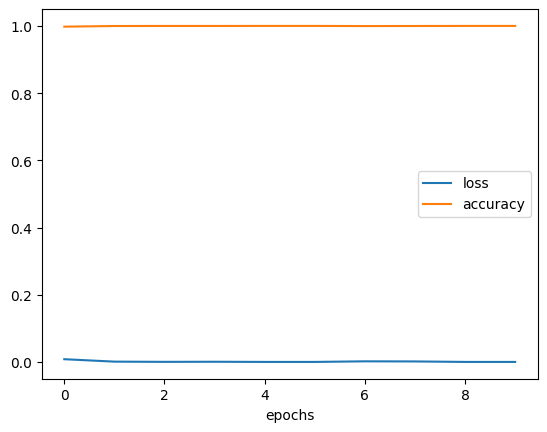

In [145]:
print(history.history.keys())
plt.plot(range(0,epochs),history.history['loss'],label='loss')
plt.plot(range(0,epochs),history.history['accuracy'],label='accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

# Predicting $\beta_c$



## Iterate through each beta value and calculate its mean

In [131]:
# Reshape x_test for conv2d input layer
x_test=x_test.reshape((len(x_test),L,L,1))

# Predictions on x_test
y_pred = model.predict(x_test)

# Number of calculated betas and configurations per beta
Nbetas = 50
Nconfigsperbeta = 1000

# Averaged predictions on first and second output neurons (0 and 1)
predict0 = []
predict1 = []

# Iterate through each beta value and calculate its mean
for i in range(Nbetas):
  aux_matrix = y_pred[i*Nconfigsperbeta:(i+1)*Nconfigsperbeta-1]
  aux1 = np.mean(aux_matrix[:,0])
  aux2 = np.mean(aux_matrix[:,1])
  predict0.append([aux1])
  predict1.append([aux2])

# Convert to numpy arrays
predict0=np.array(predict0)
predict1=np.array(predict1)

1563/1563 [==============================] - 10s 6ms/step


## Plot output neurons vs $\beta$

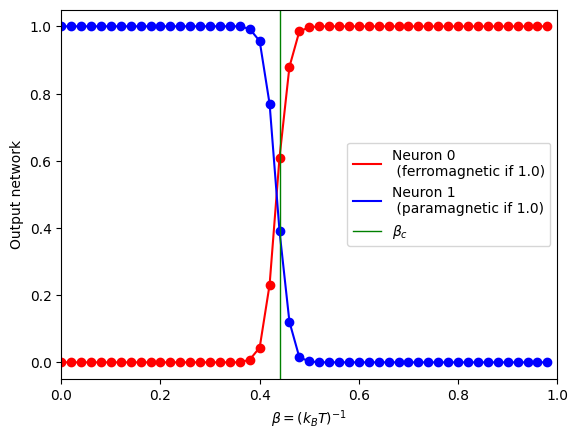

In [144]:
# Numerical beta_c
beta_c=0.4406

# Plot the results
x_beta=np.unique(y_test)
plt.scatter(x_beta, predict0, c='r')
plt.scatter(x_beta, predict1, c='b')
plt.plot(x_beta, predict0, c='r', label = 'Neuron 0 \n (ferromagnetic if 1.0)')
plt.plot(x_beta, predict1, c='b', label = 'Neuron 1 \n (paramagnetic if 1.0)')
plt.xlabel(r'$\beta=(k_B T)^{-1}$')
plt.ylabel("Output network")
plt.axvline(x=beta_c, linewidth=1, color='g', label = r'$\beta_c$')
plt.legend()
plt.xlim(0.0, 1.0)
plt.show()